1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark.

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



The quantile function of a random variable $X$ evaluated at probability $p$ is the value $x$ such that the probability of $X$ being smaller than said $x$ is $p$

$Q_{X}(p)=\{x:\text{Pr}(X\leq x)=p\}$

Note that Pr$(X\leq x)$ is the cumulative distribution of $X$ so that if $F_{X}$ is invertible (which it usually is) it is the inverse of the quantile function

$Q_{X} = F_{X}^{-1}$

In [2]:
!wget -q -nc https://github.com/GiancarloSaran/LaboratoryOfComputationalPhysics_Y6/raw/main/max-speeds.npy

from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
max_speeds = np.load('max-speeds.npy', allow_pickle=True)
years_nb = max_speeds.shape[0]
years = np.arange(years_nb)
cprob = years/(years_nb+1)
sort_speeds = np.sort(max_speeds)
spl = UnivariateSpline(cprob, sort_speeds)
pred = spl(0.98)
print(pred)

34.63345579700954


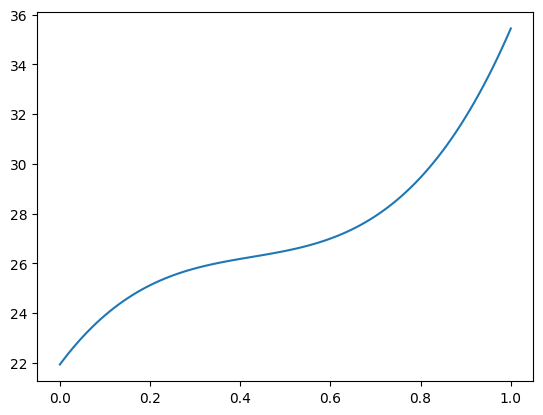

In [ ]:
#Plot the percentile/quantile function
x = np.linspace(0, 1, 100)
plt.plot(x, spl(x))
#One could have also estimated the parameters of the normal distribution from the data
#and calculated the quantile from there using the norm.ppf scipy builtin

2\. **Curve fitting of temperature in Alaska**

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures.
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

We assume that temperatures are best fit by a periodic function of period 1 year. Since the lowest temperature is around January the most comfortable function is
$f(x) = T_0 - A\cos(k(x-x_0))$

Where $k=2\pi/12 \text{ months}^{-1}$ so the warmest month is $x_m : x_m - x_0 = \pi/k\implies x_m = 6+x_0$

Warmest day according to maximums Jul 1
Warmest day according to minimums Jul 5
offset: 4.7 +- 5.8


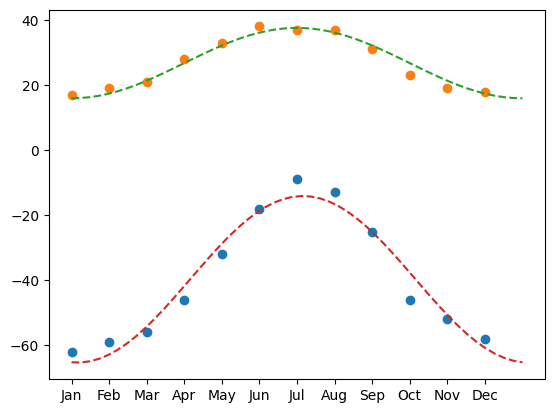

In [64]:
from scipy import optimize
import calendar

def f(x, A, x0, off):
  k = 2*np.pi/12 #expected period 12 months
  return off-A*np.cos(k*(x-x0))

max = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
range = np.arange(12)
#Adjust month names
month = [mon[:3] for mon in calendar.month_name[1:]]
plt.plot(month, min, 'o')
plt.plot(month, max, 'o')
bound = ([0, 0, -np.inf], [np.inf, 2*np.pi, np.inf])
params_max = optimize.curve_fit(f, range, max, bounds=bound)
params_min = optimize.curve_fit(f, range, min, bounds=bound)

x = np.linspace(0, 12)
plt.plot(x, f(x, *params_max[0]), '--')
plt.plot(x, f(x, *params_min[0]), '--')

#Two estimated peaks
#Assuming equal month length
l = 365.25/12
max_fit, min_fit = params_max[0], params_min[0]
var_max_fit, var_min_fit = params_max[1][1, 1], params_min[1][1, 1]
max_day, min_day = l*(6 + max_fit[1]), l*(6 + min_fit[1])

#Peak dates
print(f'Warmest day according to maximums {month[int(max_day/l)]} {1+int(max_day-int(max_day/l)*l)}')
print(f'Warmest day according to minimums {month[int(min_day/l)]} {1+int(min_day-int(min_day/l)*l)}')

#Peaks offset
off_days = (min_day-max_day)
off_err = 365/12*np.sqrt(var_max_fit+var_min_fit)
print(f'offset: {off_days:.1f} +- {off_err:.1f}')
#The time offsets are compatible within fit accuracy

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


[-0.0898419   0.71265669]
[ 0.08984189 -0.7126567 ]
-1.0316284534891136
-1.0316284534890687


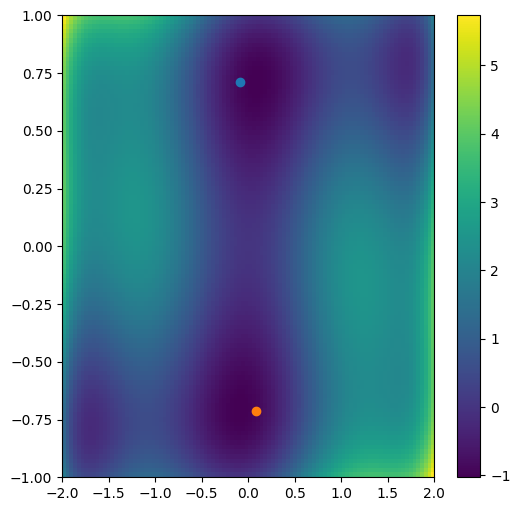

In [ ]:
import scipy.optimize as opt

def f(v):
  x, y = v[0], v[1]
  return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2

nx = ny = 100
x = np.linspace(-2, 2, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
map = f([X, Y])
fig, ax = plt.subplots(figsize=(6,6))
plot = ax.imshow(map, extent=[-2,2,-1,1], aspect='auto')
fig.colorbar(plot)
#There seem to be two global minima and two other local minima
guess = np.array([0, 0.9])
lim = ((-2, 2), (-1, 1))
minup = opt.minimize(f, x0=guess, bounds=lim).x
mindown = opt.minimize(f, x0=-guess, bounds=lim).x
print(minup)
print(mindown)
print(f(minup))
print(f(mindown))
plt.scatter(*minup)
plt.scatter(*mindown)

[0. 0.]
[-0.08984283  0.71265623]
[ 0.08984282 -0.71265624]


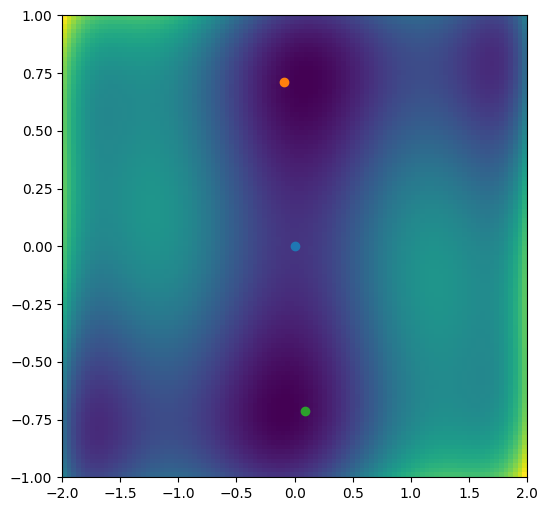

In [ ]:
#The two minima are identical up to the 12th decimal place, safe to assume they're both global
#What if we start at (0,0)?
epsilon = 0.01
fig, ax = plt.subplots(figsize=(6,6))
plot = ax.imshow(map, extent=[-2,2,-1,1], aspect='auto')
minzero = opt.minimize(f, x0=[0, 0], bounds=lim).x
print(minzero)
plt.scatter(*minzero)
minupzero = opt.minimize(f, x0=[0, 0+epsilon], bounds=lim).x
mindownzero = opt.minimize(f, x0=[0, 0-epsilon], bounds=lim).x
print(minupzero)
plt.scatter(*minupzero)
print(mindownzero)
plt.scatter(*mindownzero)
#Calculating the gradient and hessian of f one can easily find (0,0) is a local maximum,
#in fact if one tries to tweak the guess slightly towards one of the two minima the
#algorithm converges again to an actual minima

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

In [ ]:
from scipy import fftpack #Note that it's deprecated in favor of scipy.fft
def spectrum(signal, label=None):
  #Simple frequency analysis finds the maximum power and plots the spectrum
  #This assumes there is a dominating frequency
  fft_signal = fftpack.fft(signal)
  power = np.abs(fft_signal)
  freqs = fftpack.fftfreq(signal.size, d=1)
  #Filter negative frequencies
  power = power[freqs>0]
  freqs = freqs[freqs>0]
  #Plot the spectrum
  plt.plot(freqs, power, label=label)
  plt.legend()
  return freqs[np.argmax(power)]

Hares period: 10.5 years
Lynxes period: 10.5 years


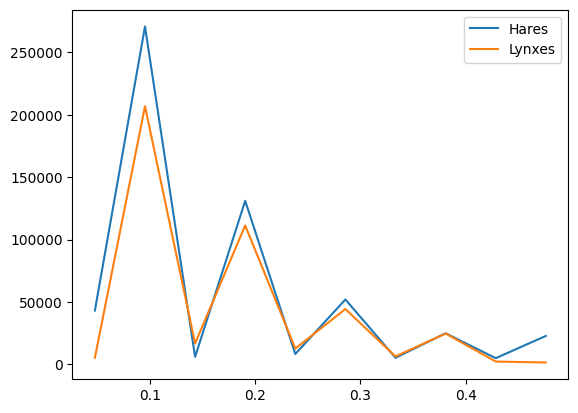

In [ ]:
! wget -q -nc https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt

nd = np.loadtxt('populations.txt', dtype=float)
nd = nd.astype(int)
hares = nd[:, 1]
lynxes = nd[:, 2]
print(f"Hares period: {1/spectrum(hares, label='Hares')} years")
print(f"Lynxes period: {1/spectrum(lynxes, label='Lynxes')} years")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

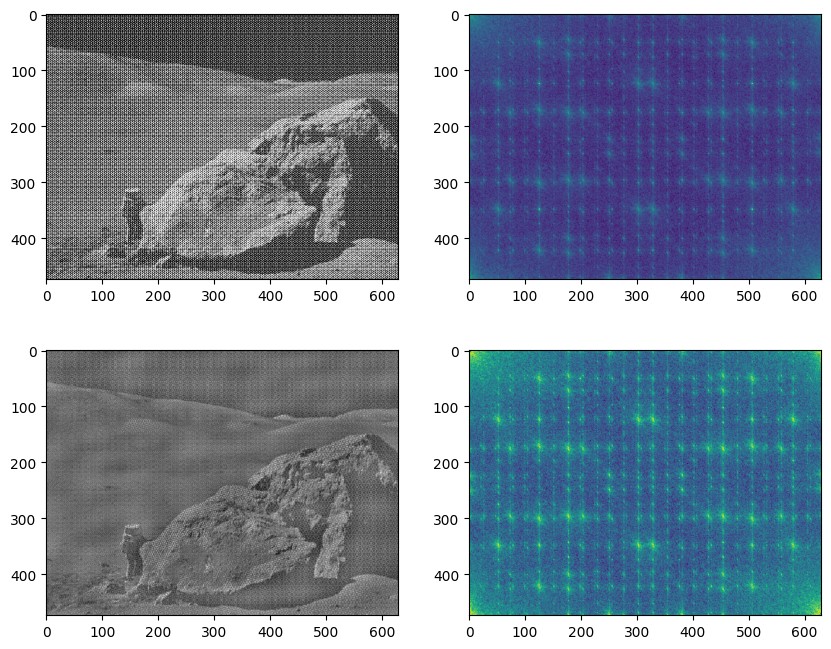

In [ ]:
!wget -q -nc https://github.com/GiancarloSaran/LaboratoryOfComputationalPhysics_Y6/raw/main/moonlanding.png

from matplotlib.colors import LogNorm
#embellish the plot later
img = plt.imread('moonlanding.png')
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].imshow(img, plt.cm.gray)
img_fft = fftpack.fft2(img)
power = np.abs(img_fft)
x_spec = fftpack.fftfreq(img.shape[0], d=1)
y_spec = fftpack.fftfreq(img.shape[1], d=1)
ax[0,1].imshow(power, norm=LogNorm(vmin=5))
#filter the data by power (without using frequency spectrum, you risk cutting off some data)
#we could also filter data by frequency
p = 99.9
filter_p = img_fft.copy()
filter_p[power > np.percentile(power, p)] = 0
ax[1,1].imshow(np.abs(filter_p), norm=LogNorm(vmin=5))
#replot the filtered image
fp_img = fftpack.ifft2(filter_p).real
ax[1,0].imshow(fp_img.real, plt.cm.gray)